In [ ]:
reset_variables = False

In [15]:
import pandas as pd

# Load dataset files
print("Loading raw datasets...")

# Introduce the *paths* of the raw datasets

# Depression
data_depression = pd.DataFrame(pd.read_json("../backups/r_depression_base.jsonl", lines=True))
data_depression["depression_related"] = [1] * len(data_depression.index)  # Dep. identifier: true
dep_size = len(data_depression.index)

# Non-depression
data_control = pd.DataFrame(pd.read_json("../backups/reference_collection.jsonl", lines=True))
data_control["depression_related"] = [0] * len(data_control.index)  # Dep. identifier: false
non_dep_size = len(data_control.index)

print("Raw datasets successfully loaded")

Loading raw datasets...
Raw datasets successfully loaded


In [30]:
# In case you want to analyze the author posts
authors_depression = pd.read_excel("../data/subr_authors_selected.xlsx")
authors_reference = pd.read_excel("../data/ref_authors_selected.xlsx")

authors_depression = authors_depression.loc[:, authors_depression.columns != "Unnamed: 0"]
authors_reference = authors_reference.loc[:, authors_reference.columns != "Unnamed: 0"]

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def process_bar_chart(ax, title, x_name, y_name, horizontal, values):
    """
    Function that decorates a chart given an Axes object
    
    :param ax: Axes - object containing all the information needed to plot
    :param title: str - the title of the chart
    :param x_name: str - the name of the x-axis label
    :param y_name: str - the name of the y-axis label
    :param horizontal: bool - True if it's a horizontal chart (to inverse the values)
    :param values: bool - True if you want labels to be added to your chart (currently only supported
    for horizontal charts, so both need to be True) 
    """
    ax.set_title(title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    if horizontal:
        ax.invert_yaxis()
    for tick in ax.get_xticks():
        ax.axvline(x=tick, linestyle="dashed", alpha=0.35, color="black", zorder=1, lw=0.75)
    for tick in ax.get_yticks():
        ax.axhline(y=tick, linestyle="dashed", alpha=0.35, color="black", zorder=1, lw=0.75)
    if horizontal and values:
        for i, val in enumerate(ax.patches):
            # x (+ little offset), y, text, color, font
            plt.text(val.get_width() + 0.5, i, str(val.get_width()), color="black", fontweight="bold")
    plt.tight_layout()

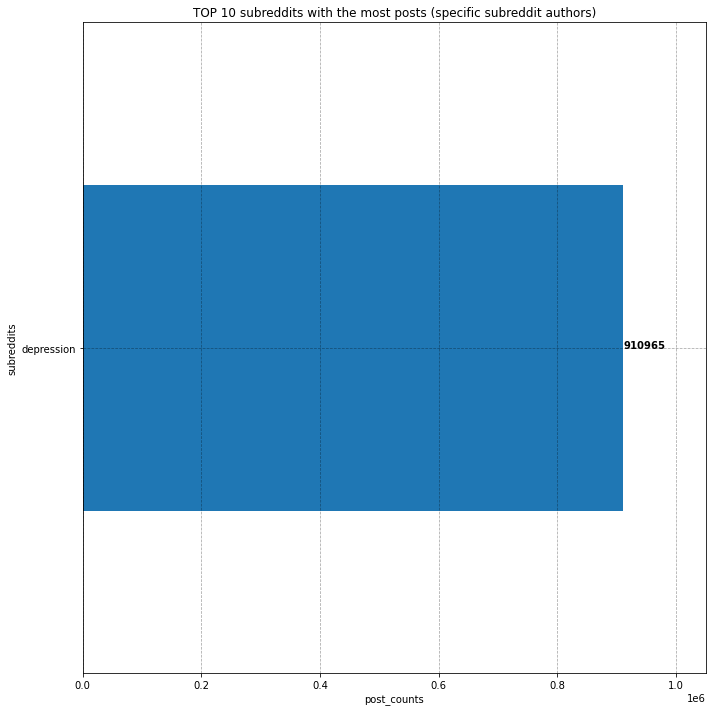

In [3]:
# Subreddits' post count
dep_subreddits = data_depression["subreddit"].value_counts(sort=True)
axes = dep_subreddits[:10].plot(kind="barh", figsize=(10, 10), x="subreddit")
process_bar_chart(axes, "TOP 10 subreddits with the most posts (specific subreddit authors)", "post_counts",
                   "subreddits", True, True)
plt.savefig("./img/dep_subreddits.png")

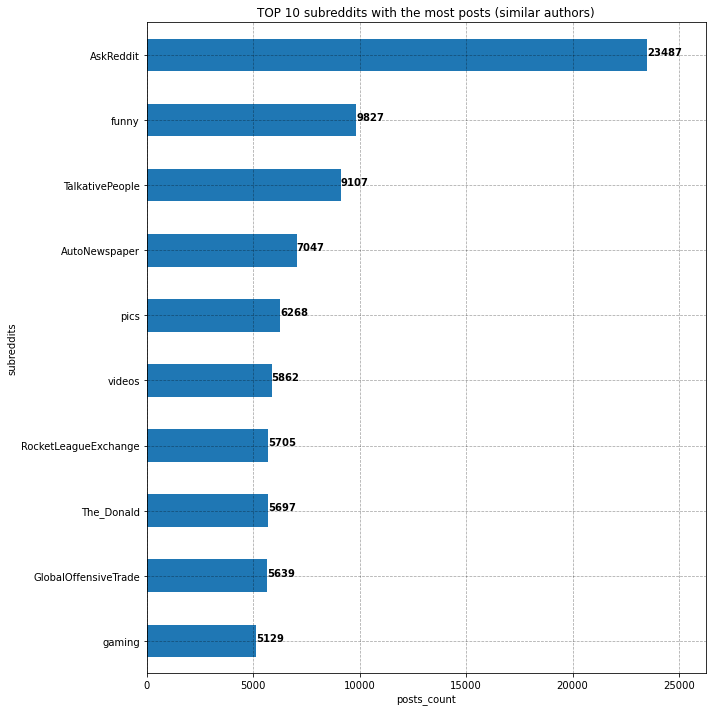

In [4]:
# Subreddits' post count
ctrl_subreddits = data_control["subreddit"].value_counts(sort=True)
axes = ctrl_subreddits[:10].plot(kind="barh", figsize=(10, 10), x="subreddit")
process_bar_chart(axes, "TOP 10 subreddits with the most posts (similar authors)", "posts_count", "subreddits", True,
                   True)
plt.savefig("./img/ctrl_subreddits.png")

In [4]:
import os

for series in [dep_subreddits, ctrl_subreddits]:
    series.name = "posts_count"

with pd.ExcelWriter("../data/top_subreddits.xlsx") as writer:
    dep_subreddits.to_excel(writer, sheet_name="depression")
    ctrl_subreddits.to_excel(writer, sheet_name="reference")

depressed = set()
for items in [dep_subreddits.iteritems(), ctrl_subreddits.iteritems()]:
     for item in items:
         if "depress" in item[0] and item[0] not in depressed:
             depressed.add(item[0])

path = "../data/dep_subreddits.txt"
file_depressed = set()
if os.path.isfile(path):
    with open(path, "r") as file:
        for subr in file:
            file_depressed.add(subr.strip("\n"))

to_remove = depressed.union(file_depressed)
with open(path, "a+") as file:
    for subr in to_remove:
        file.write(subr + "\n")

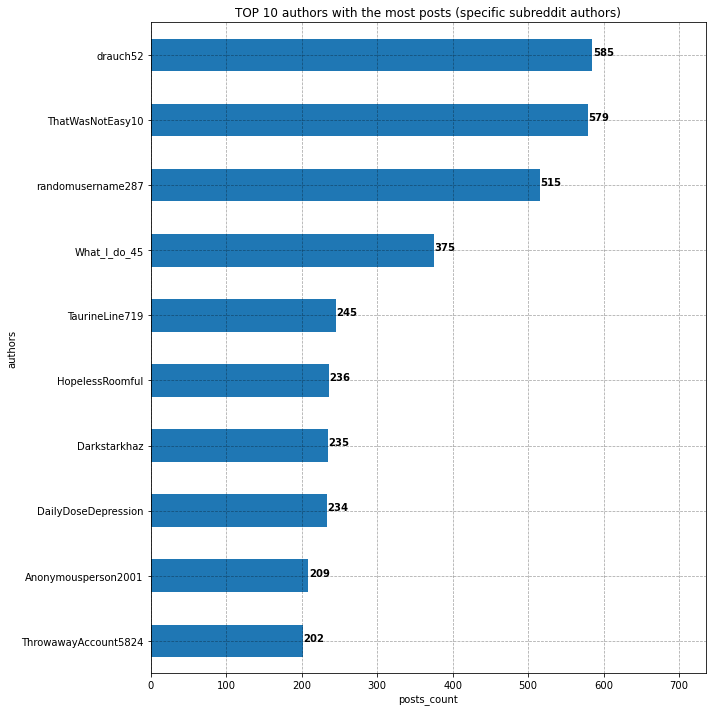

In [19]:
# Authors' post count
dep_authors = data_depression.loc[data_depression["author"] != "[deleted]"]["author"].value_counts(sort=True)
# Plot
axes = dep_authors[:10].plot(kind="barh", figsize=(10, 10), x="author")
process_bar_chart(axes, "TOP 10 authors with the most posts (specific subreddit authors)", "posts_count", "authors",
                   True, True)
plt.savefig("./img/dep_authors.png")

In [ ]:
# Complete authors' data with their posts' count
authors_depression["posts_count"] = authors_depression["username"].apply(
    lambda usr: int(dep_authors[usr]) if usr in dep_authors else 0)

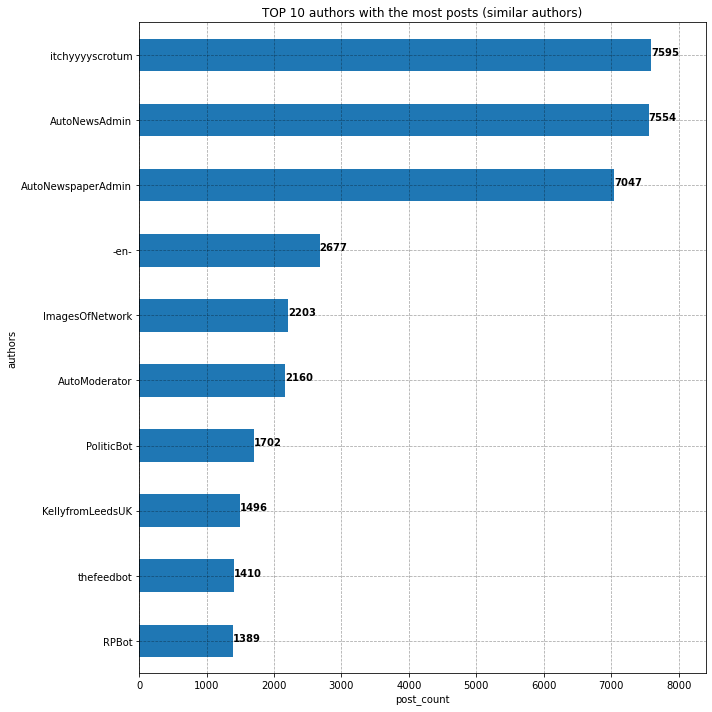

In [20]:
# Authors' post count
ctrl_authors = data_control.loc[data_control["author"] != "[deleted]"]["author"].value_counts(sort=True)
# Plot
axes = ctrl_authors[:10].plot(kind="barh", figsize=(10, 10), x="author")
process_bar_chart(axes, "TOP 10 authors with the most posts (similar authors)", "post_count", "authors", True, True)
plt.savefig("./img/ctrl_authors.png")

In [ ]:
# Complete authors' data with their posts' count
authors_reference["posts_count"] = authors_reference["username"].apply(
    lambda usr: int(ctrl_authors[usr]) if usr in ctrl_authors else 0)

In [37]:
# Concatenate the dataframes with the authors' info + their posts' count and save it to a new excel file
# where even rows are subreddit specific authors and odd rows, their reference pairs (i.e row 0, representing the first
# author of the subreddit authors, relates with row 1, the first pair of the reference dataset)
concatenated_authors = pd.concat([authors_depression, authors_reference]).sort_index().reset_index(drop=True)
concatenated_authors.to_excel("../data/all_authors_selected.xlsx")

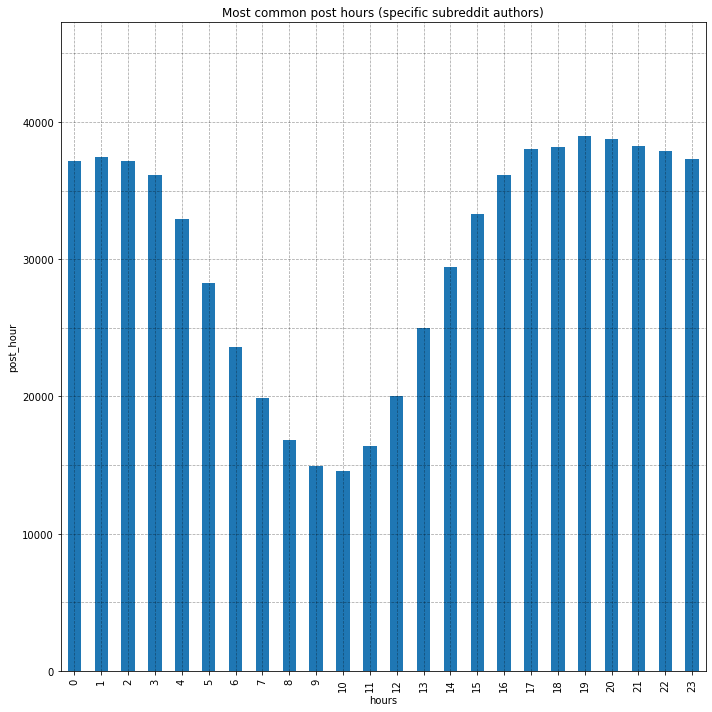

In [38]:
# Most common post hours
data_depression["post_hour"] = pd.to_datetime(data_depression["created_utc"], unit="s").apply(lambda dt: dt.hour)
dep_hours = (data_depression["post_hour"].value_counts()).sort_index()

axes = dep_hours.plot(kind="bar", figsize=(10, 10), x="post_hour",
                      title="Most common post hours (specific subreddit authors)")
process_bar_chart(axes, "Most common post hours (specific subreddit authors)", "hours", "post_hour", False, False)
plt.savefig("./img/dep_hours.png")

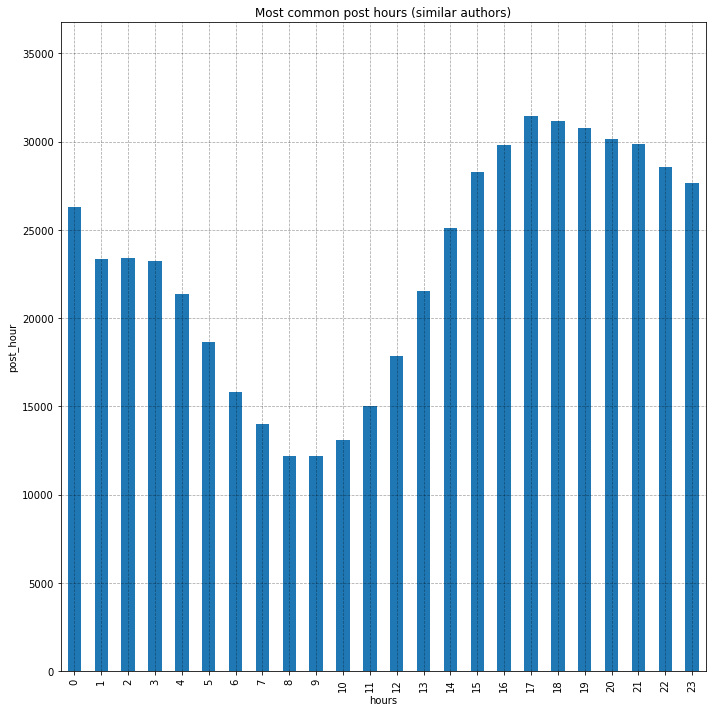

In [39]:
# Most common post hours
data_control["post_hour"] = pd.to_datetime(data_control["created_utc"], unit="s").apply(lambda dt: dt.hour)
ctrl_hours = (data_control["post_hour"].value_counts()).sort_index()

axes = ctrl_hours.plot(kind="bar", figsize=(10, 10), x="post_hour")
process_bar_chart(axes, "Most common post hours (similar authors)", "hours", "post_hour", False, False)
plt.savefig("./img/ctrl_hours.png")

In [22]:
if reset_variables:
    %reset -f